In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product

from copy import deepcopy
from tqdm.notebook import tqdm
import ordpy
from scipy.stats import mode

In [3]:
def runge_kutta(time_steps, y0, system, params):
    ys = [y0]
    for t in range(len(time_steps)-1):
        dt = time_steps[t+1]-time_steps[t]
        t0 = time_steps[t]
        t1 = time_steps[t+1]
        k1 = system(t0, y0, params)
        k2 = system(t0 + dt/2, y0 + dt / 2 * k1, params)
        k3 = system(t0 + dt/2, y0 + dt / 2 * k2, params)
        k4 = system(t1, y0 + dt * k3, params)
        y0  = y0 + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        ys.append(y0)
    return np.array(ys)

def lorentz_ode(t, xyz, params):
    x, y, z = xyz
    σ = params['σ']
    ρ = params['ρ']
    β = params['β']
    
    dx = σ * (y - x)
    dy = x * (ρ - z) - y
    dz = x * y - β * z
    
    return np.array([dx, dy, dz])

def get_data(p1 = 10., p2 = 28., p3 = 8/3):
    time_steps = np.arange(0, 1500, 0.1)
    params = {'σ' : p1, 'ρ' : p2, 'β' : p3}
    xyz0 = np.array([1., 1., 1.])
    lorenz_solution = runge_kutta(time_steps, xyz0, lorentz_ode, params)
    x, y, z = lorenz_solution[2000:].T

    x = (x - min(x)) / (max(x) - min(x))
    return x

In [4]:
# Hyper params
L = 4 # length of pattern
K = 10 # maximal value of pattern element

step = 50
M = 20

predicted_points_number = 50

In [5]:
# Builds matrix of patterns
z_vectors = np.array(list(product(np.arange(1, K + 1), repeat=L)))
patterns = np.cumsum(z_vectors, axis=1)
patterns = np.hstack([np.zeros((z_vectors.shape[0], 1)), patterns]).astype(int)

In [6]:
# Compute motives for train_data vector based on train_points number form point start

def fit(train_data, train_points_number, start, current_iter=1, max_iter=1):
    global patterns

    z_vectors_list = []
    for i in tqdm(range(patterns.shape[0]), desc=f"Computing matrix of Z-vectors, iteration {current_iter}/{max_iter}", leave=False):
        pattern = patterns[i]
        vecs = []
        for j in range(train_points_number - pattern[-1]):
            vecs.append(train_data[pattern + j + start])
        z_vectors_list.append(np.array(vecs))
    return z_vectors_list

In [7]:
# Normalizing matrix

def norm(a):
    return np.sqrt(np.sum(np.square(a), axis=1))

In [8]:
# Predictions on train_data based on motives list by predicted_points_number points
# with max_dist between vectors and maximal allowed MAPE max_mape

def predict_with_demon(train_data, motives, begin, predicted_points_number, max_dist=0.05, max_mape=0.05):
  global patterns

  x_with_predictions = deepcopy(train_data) # copy of train_data with predictions
  for T in tqdm(range(begin, begin + predicted_points_number), desc="Demon predictions", leave=False):
      St = []
      # for i in tqdm(range(patterns.shape[0]), desc="Inner loop", leave=False):
      for i in range(patterns.shape[0]):
          normalized_predicted = norm(motives[i][:, :-1] - x_with_predictions[(patterns[i] + T - patterns[i][-1])[:-1]])
          St.extend(motives[i][(normalized_predicted < max_dist), :][:, -1])
      if len(St) == 0:
         predicted_value = np.inf
      else:
         predicted_value = mode(St, keepdims=True).mode[0]
         if abs(predicted_value - train_data[T]) / train_data[T] > max_mape:
            predicted_value = np.inf
      x_with_predictions[T] = predicted_value
  return x_with_predictions[begin : begin + predicted_points_number]

In [9]:
x = get_data()
points_number = x.shape[0]

In [10]:
def calculate(train_points_number, begin):
    actual_vals_matrix = []
    predicted_vals_matrix = []
    
    motives_list = []

    for i in tqdm(range(M), "Overall iterations loop"):
        start = begin + step * i
        motives = fit(x, train_points_number, start, current_iter=i + 1, max_iter=M)
        motives_list.append(motives)

        actual_vals = x[start + train_points_number : start + train_points_number + predicted_points_number]
        predicted_vals = predict_with_demon(x, motives, start + train_points_number, predicted_points_number)

        actual_vals_matrix.append(actual_vals)
        predicted_vals_matrix.append(predicted_vals)

    actual_vals_matrix = np.array(actual_vals_matrix)
    predicted_vals_matrix = np.array(predicted_vals_matrix)

    loss = np.zeros((predicted_points_number))
    unpredicted_points = np.zeros((predicted_points_number))

    for i in range(M):
        for j in range(predicted_points_number):
            if predicted_vals_matrix[i][j] == np.inf:
                unpredicted_points[j] += 1
            else:
                loss[j] += abs(predicted_vals_matrix[i][j] - actual_vals_matrix[i][j]) * 100 / actual_vals_matrix[i][j]
    loss /= M
    unpredicted_points /= M

    return actual_vals_matrix, predicted_vals_matrix, loss, unpredicted_points, motives_list

In [11]:
def calculate_based(train_points_number, motives, begin, max_dist=0.05):
    actual_vals_matrix = []
    predicted_vals_matrix = []

    for i in tqdm(range(M), "Overall iterations loop"):
        start = begin + step * i

        actual_vals = x[start + train_points_number : start + train_points_number + predicted_points_number]
        predicted_vals = predict_with_demon(x, motives[i], start + train_points_number, predicted_points_number, max_dist)

        actual_vals_matrix.append(actual_vals)
        predicted_vals_matrix.append(predicted_vals)

    actual_vals_matrix = np.array(actual_vals_matrix)
    predicted_vals_matrix = np.array(predicted_vals_matrix)

    loss = np.zeros((predicted_points_number))
    unpredicted_points = np.zeros((predicted_points_number))

    for i in range(M):
        for j in range(predicted_points_number):
            if predicted_vals_matrix[i][j] == np.inf:
                unpredicted_points[j] += 1
            else:
                loss[j] += abs(predicted_vals_matrix[i][j] - actual_vals_matrix[i][j]) * 100 / actual_vals_matrix[i][j]
    loss /= M
    unpredicted_points /= M

    return actual_vals_matrix, predicted_vals_matrix, loss, unpredicted_points

In [12]:
def plots(train_points_number, loss, unpredicted_points):
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(f"Trained on original series, train_size={train_points_number}")

    plt.subplot(1, 2, 1)
    plt.title("MAPE, %")
    plt.grid()
    plt.plot(loss)

    plt.subplot(1, 2, 2)
    plt.ylim((-0.1, 1.1))
    plt.grid()
    plt.title("Unpredicted points")
    plt.plot(unpredicted_points)

    plt.show()

In [ ]:
data0 = calculate(train_points_number=1000, begin=0)

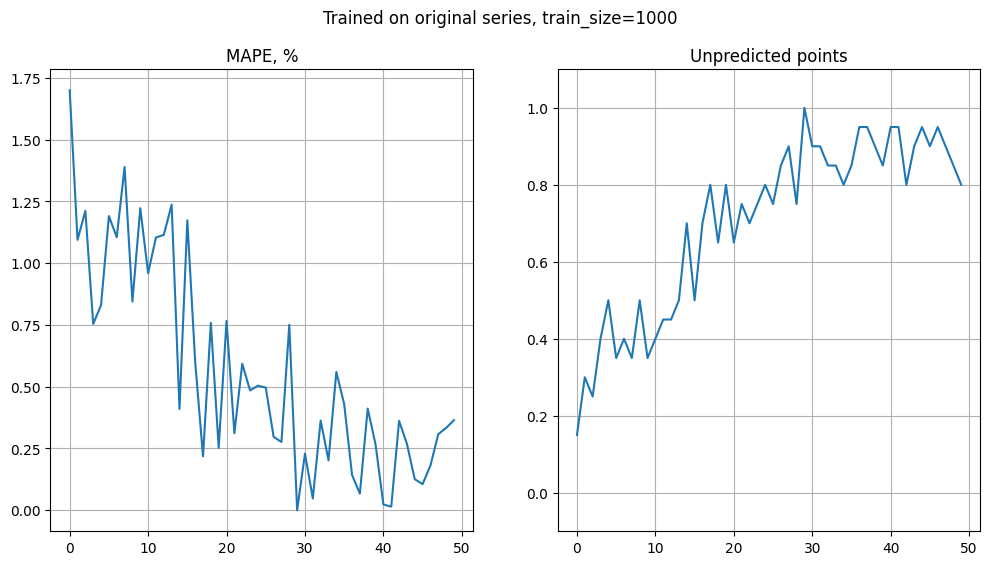

In [14]:
plots(train_points_number=1000, loss=data0[2], unpredicted_points=data0[3])

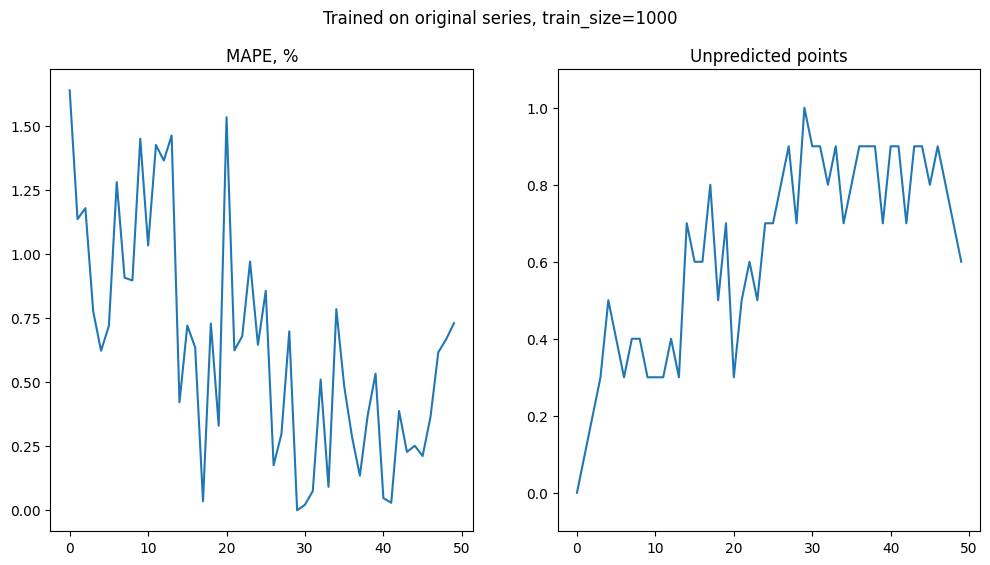

In [ ]:
plots(train_points_number=1000, loss=data0[2], unpredicted_points=data0[3])

In [ ]:
print(np.mean(data0[3]))

0.626


Start

In [ ]:
data1 = calculate(train_points_number=1000, begin=9000)

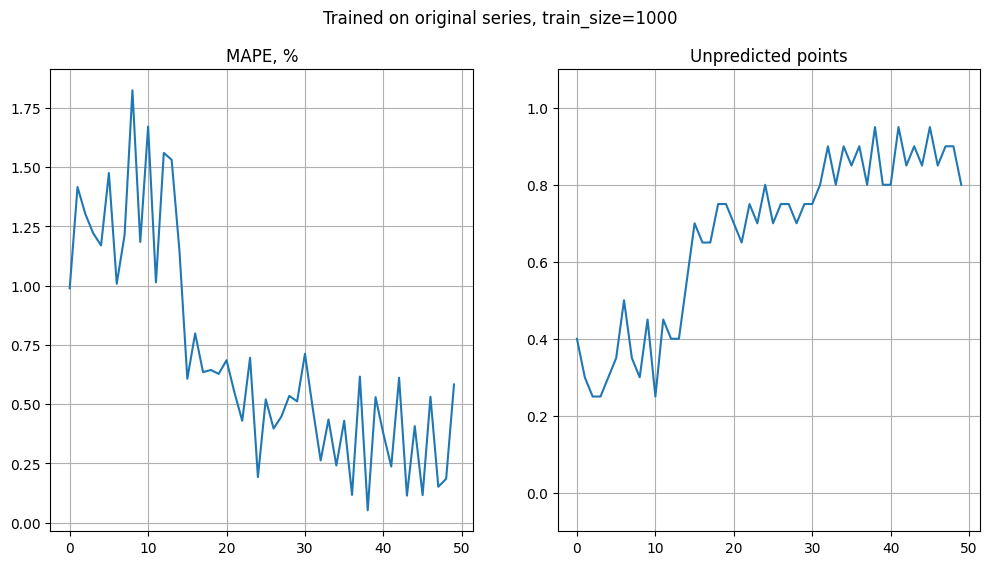

In [16]:
plots(train_points_number=1000, loss=data1[2], unpredicted_points=data1[3])

In [17]:
print(np.mean(data1[3]))

0.6689999999999999


In [ ]:
data2 = calculate(train_points_number=2500, begin=7500)

In [ ]:
plots(train_points_number=2500, loss=data2[2], unpredicted_points=data2[3])

In [ ]:
data3 = calculate(train_points_number=5000, begin=5000)

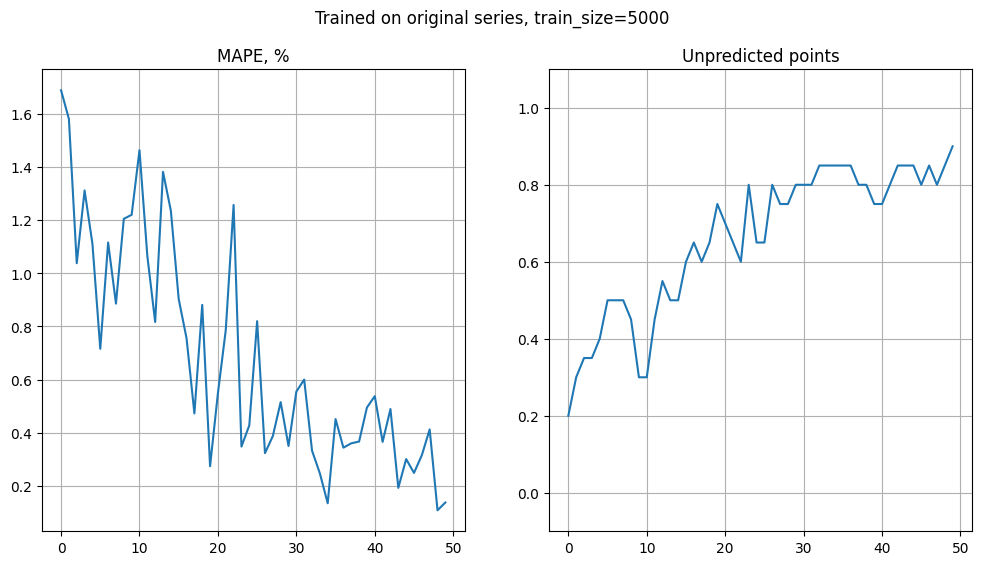

In [19]:
plots(train_points_number=5000, loss=data3[2], unpredicted_points=data3[3])

In [20]:
print(np.mean(data3[3]))

0.6609999999999999


In [ ]:
data4 = calculate(train_points_number=10000, begin=0)

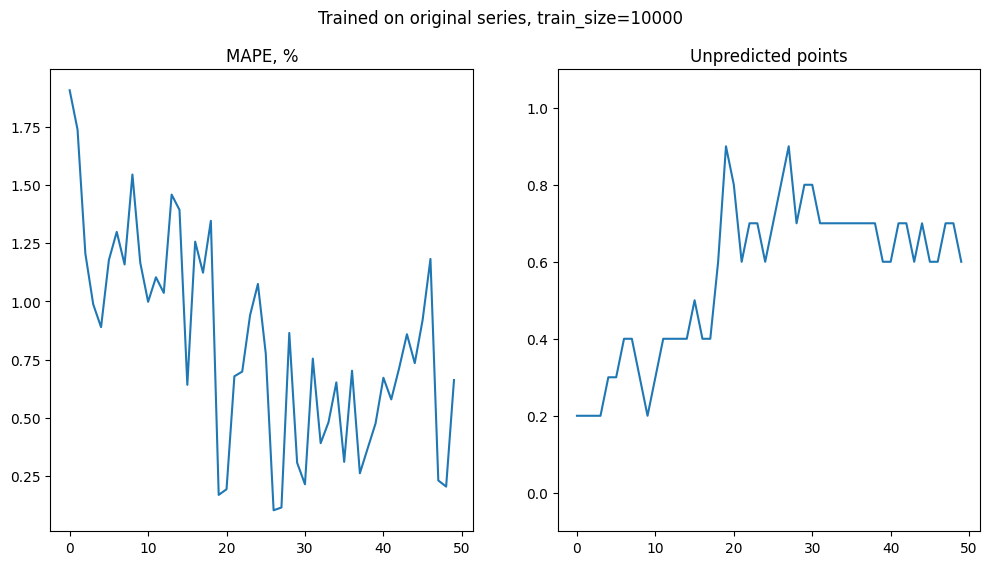

In [ ]:
plots(train_points_number=10000, loss=data4[2], unpredicted_points=data4[3])

In [ ]:
print(np.mean(data4[3]))

0.564


In [ ]:
print(np.mean(data1[3]))
# print(np.mean(data2[3]))
print(np.mean(data3[3]))
print(np.mean(data4[3]))

In [15]:
import csv

DATA = [data0]
with open('diff_sizes1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for i, data in enumerate(DATA):
        writer.writerow(list(map(str, data[2])))
        writer.writerow(list(map(str, data[3])))
        if i + 1 < len(DATA):
            writer.writerow("-" * 100)